![@SHF_2025_LA_fires](image.jpg)

## About this project
In this project we will be using true and false color imagery to examine the impacts of two fires which struck the Los Angeles area in early 2025. 

### Highlights: 
- Extracting color bands from `xarray`
- Mapping using true and false color imagery
- Overlaying fire perimiters to see effect of fires

### Background information
The Palisades and Eaton fires sparked within hours of each other on January 7th 2025. Due to arid conditions and the Santa Ana winds these fires quickly grew out of control, ultimately burning a combined 40,000 acres [@vanauken_2025]. The fires led to significant damage and economic loss, estimated between $135 billion and $150 billion [@accuweather_2025]. In this project we will examine the total land area covered by the fires as well as examine socioeconomic factors to interpret the communities affected by, as well as the long lasting effects of the fires.


### About the data: 

#### Palisades and Eaton fire perimeters 
These contain dissolved fire perimeters/boundaries for Eaton and Palisades fires, with boundary polygons dissolved for each fire to create a single fire burn perimeter. Access given by the County of Los Angeles [@la_fire_perimeters_2025]

#### Netcdf Landsat data
Landsat C2 L2 from Microsoft's Planetary Computer is a globally available, multi-decadal archive of atmospherically corrected, analysis-ready Landsat imagery. Surface reflectance for multispectral bands and derived land surface temperature from thermal bands are provided in cloud-optimized GeoTIFFs, accessible via a STAC API. Accordingly, it is primarily used for long-term environmental monitoring, spectral studies, and thermal remote sensing, and is designed for scalable, cloud-native remote sensing workflows [@landsat_c2_l2_2025]

### 1. Import packages and datasets

In [1]:
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import os 
import xarray as xr
import rioxarray as rio
import numpy as np 
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx



### 2. Fire perimeter data exploration

Here we import the perimeter data files and do some exploration.

I am going to import both perimeters and then look at the CRS, or coordinate reference system. This allows us to map all datasets using the same projection.

In [2]:
fp = os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp')
eaton_perimeter = gpd.read_file(fp)

In [3]:
fp = os.path.join('data','Palisades_Perimeter_20250121','Palisades_Perimeter_20250121.shp')
palisades_perimeter = gpd.read_file(fp)

In [4]:
# Now we can look at the crs's and do some exploration 
palisades_perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
eaton_perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We know we want to merge these datasets at some point, so it is important to check if the column names match in the two perimeters

In [6]:
# Lets compare the column names to make sure they match 

print(f' It is {eaton_perimeter.columns == palisades_perimeter.columns} that the column names match')

 It is [ True  True  True  True  True] that the column names match


In [7]:
# Thats great we only need to look at one of the dataframes columns 

print(' The column names of the data frames are', eaton_perimeter.columns)

 The column names of the data frames are Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry'], dtype='object')


*Summary:* From the preliminary exploration both the Palisades and Eaton datasets are in ESPG:3857, which is a projected coordinate system. Both have the same column names which will make analysis and merging easier. 

### 3. NetCDF data import and exploration
Here we will import and explore the Landsat data using `xr.open_dataset()`. 



In [ ]:
netcdf = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')
netcdf

This `xarray` has 1418 y dimensions and 2742 x dimensions. The coordinates are x, y, and time which are are float64, float64, and datetime64 types (respectively). The variables are red, green, blue, near infared and short wave infared light bands as well as a spatial reference. The bands are in float32 while the spatial_ref is an int64, this shouldn't be an issue going further - however as the analysis continues it may become an issue. 

### 4. Restoring geospatial information
We need to use `rio.crs` to print what is the CRS of this dataset, which will help us plot the light bands onto the same area as the fire perimeters. 




In [10]:
print(f'The xarray has the crs: {netcdf.rio.crs}')


The xarray has the crs: None


Oh no! Theres no CRS meaning that it will be harder to plot, however there actually is! It's just encoded in the `spatial_ref` variable. 


In [49]:
print(f' The actual CRS of the xarray is: {netcdf.spatial_ref.crs_wkt}')

 The actual CRS of the xarray is: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


*Oh wow thats big!* Lets make it so that CRS is the CRS for the dataset

In [12]:
netcdf = netcdf.rio.write_crs(netcdf.spatial_ref.crs_wkt) # Need to write_crs due to being an xarrray

In [50]:
print(f'The xarray now has the CRS: {netcdf.rio.crs}')


The xarray now has the CRS: None


### 5. True color image
A true color image takes the light bands collected by Landsat and plots the colors visible to the human eye. This is how the ground would look if we were sitting on the satelite


To create a true color plot we need to: 

-  Identify which bands have nan values. 
-  Select the red, green, and blue variables (in that order) of the `xarray.Dataset` holding the Landsat data,
-  Convert it to a numpy.array using the `to_array()` method, and then
-  Use `.plot.imshow()` to create an RGB image with the data. 
-  Adjust the scale used for plotting the bands to get a true color image. 
-  Use the `.fillna()` method for `xarray.Datasets` to substitute any nan values in the Landsat data for zero.
-  Create a true color image that gets plotted without warnings.


In [14]:
print(f'The red band has {np.isnan(netcdf.red).sum().item()} na values')
print(f'The green band has {np.isnan(netcdf.green).sum().item()} na values')
print(f'The blue band has {np.isnan(netcdf.blue).sum().item()} na values')

The red band has 0 na values
The green band has 1 na values
The blue band has 109 na values


In [ ]:
netcdf[['red', 'green', 'blue']].fillna(0).to_array().plot.imshow(robust = True) # Robust and fillna allow us to plot despite the NA values

You can *sort of* see the fire damage, however it isnt as aparant as the false color image.

### 6. False color image
False color images plot short wave infared, near infared, and red bands. By assigning infrared bands to visible colors, these images highlight vegetation health, burn severity, and the extent of fire scars. This approach helps researchers and land managers assess recovery efforts, identify high-risk areas, and plan restoration strategies [@meds_eds220_thomasfire_2025]

In [16]:
# This plotting code is very similar to the other, but we are selecting bands
netcdf[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True) # Note! No Na's are present

The red areas are burn scars from the fires, and to see them better we can plot the fire perimeters on top.

### 7. Map
Here we map the fire perimeters onto the false color image. Before we plot we need to make sure that the CRS of both match

In [17]:
# Before we plot we need to ensure we are in the same crs
palisades_perimeter = palisades_perimeter.to_crs(netcdf.rio.crs)


eaton_perimeter = eaton_perimeter.to_crs(netcdf.rio.crs)

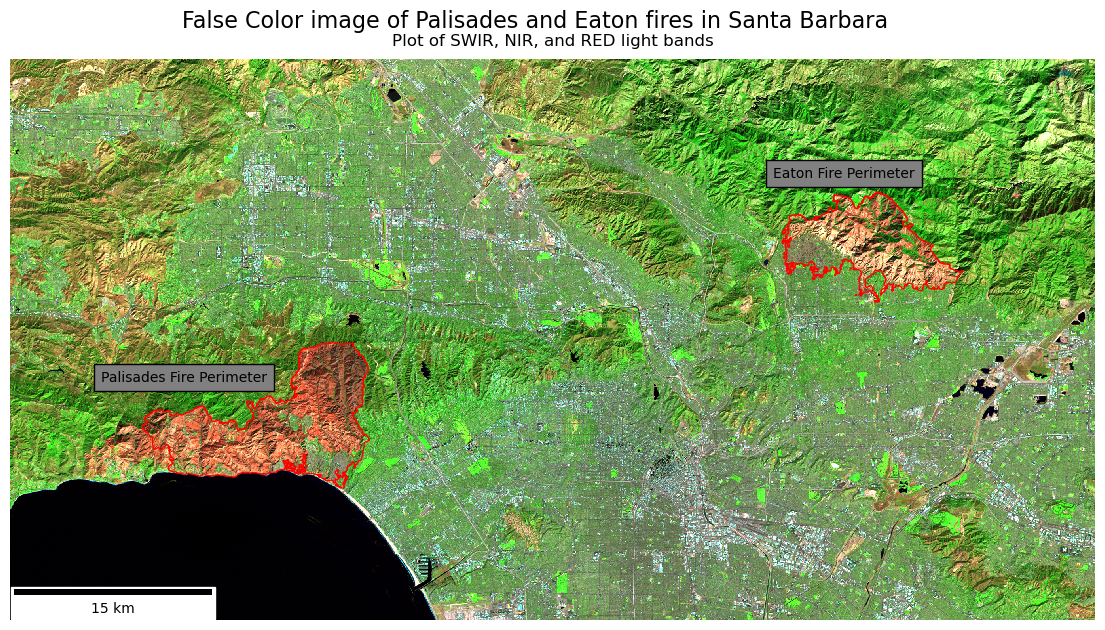

In [28]:
 

fig, ax = plt.subplots(1, 1, figsize = (14,12)) # Set a size for our figure

netcdf[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax) # Choose false color bands

eaton_perimeter.plot(ax = ax, color = 'none', edgecolor = 'red') # Plot Eaton fire perimeter in red

palisades_perimeter.plot(ax = ax, color = 'none', edgecolor = 'red') # And the Palisade perimeter


plt.suptitle('False Color image of Palisades and Eaton fires in Santa Barbara', 
             fontsize=16, 
             y = .77) # This y was a lot of guess and checking 
plt.title("Plot of SWIR, NIR, and RED light bands", 
          fontsize=12, 
          y=1.01) # Title defaults inside the plot and I want it just above, hence 1.01



plt.figtext(x = .19, # The position of the figtext, In units of 0-1 for x and y 
            y = .46,
            s = 'Palisades Fire Perimeter',
            color = 'black',
            bbox ={'facecolor':'grey',  # Add a box around text for legibility 
                   'alpha':1, 'pad':5}) 
plt.figtext(x = .67, 
            y = .63, 
            s= 'Eaton Fire Perimeter',
            color = 'black',
           bbox ={'facecolor':'grey', 
                   'alpha':1, 'pad':5})

ax.add_artist(ScaleBar(1, dimension="si-length", units="m", location="lower left")) # Add a scale bar on the lower left

ax.axis('off') # Turn Axes off

plt.show() # Show plot only 

Short-wave infrared (SWIR) was mapped to the red channel, near-infrared (NIR) to green, and the red band to blue. This false-color composite highlights post-fire effects from the January 2025 Palisades–Eaton fires. Burned areas appear as bright orange to deep red, while the fire perimeter is outlined in red for clarity, with the fire name next to the perimeter. As you can see some of the fire perimeter still contains some vegitation, thanks to our brave firefighters.

### 8. Intersection with environmental justice
In this and the following sections we will be accessing data from the California Environmental Justice Index (EJI), and plotting census count information in the context of the fire perimeters. 

We begin by importing the EJI. [@cdc_eji_2021]

In [19]:
eji_ca = gpd.read_file('/Users/petervitale/Desktop/MEDS/Career/petervitale910.github.io/posts/palisades_eaton_ejscreen/data/EJI_2024_California /EJI_2024_California.gdb')

The EJI has a number of socioeconomic factors along with geometries of where the census was taken. These include:

 * Percentage of housing units that are renter occupied: E_RENTER
 * Percentage of persons who are unisured: E_UNINSUR
 * 65+: E_AGE65
 * proportion of greenspace: E_PARK

### 9. Polygon intersection
To find where social variables intersect our fire perimeters we can use polygon intersection, where we examine where the shape of the census tracts intersect with the shape of the fire perimeter.

<Axes: >

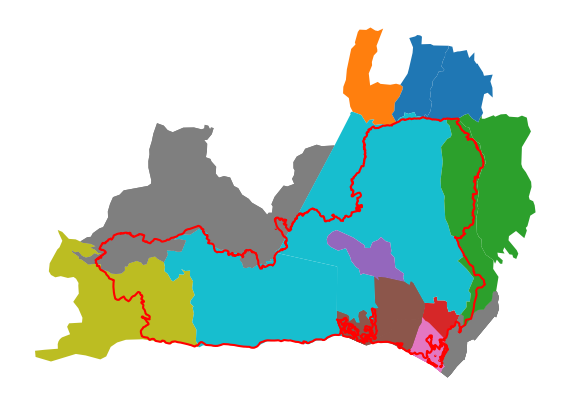

In [ ]:
# From previous exploration I know the CRS does not match 
# Spatially join EJI with palisades
pali_eji = gpd.sjoin(eji_ca.to_crs(palisades_perimeter.crs), palisades_perimeter) 

fig, ax = plt.subplots(figsize = (11,5))
ax.axis('off')
pali_eji.plot('TRACTCE',
              ax = ax)

palisades_perimeter.plot(ax = ax,
                    color = 'none',
                    edgecolor = 'red',
                    linewidth = 1.5)

Polygon intersection includes the entire census tracts that are touching the fire, see orange. This problem becomes more aparent when we plot the Eaton fire.

<Axes: >

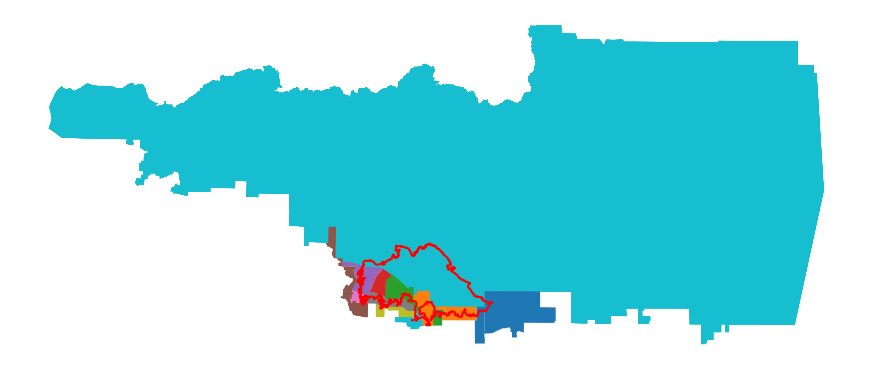

In [ ]:
# Spatially join EJI with palisades
eaton_eji = gpd.sjoin(eji_ca.to_crs(eaton_perimeter.crs), eaton_perimeter) 

fig, ax = plt.subplots(figsize = (11,5))
ax.axis('off')
eaton_eji.plot('TRACTCE',
              ax = ax)

eaton_perimeter.plot(ax = ax,
                    color = 'none',
                    edgecolor = 'red',
                    linewidth = 1.5)

As you can see a large census tract is completely included, despite a comparably small portion of the tract having been effected by the fire. 

### 10. Polygon clipping 
Instead of polygon intersection we will be using polygon clipping. If you think of cookies, polygon intersection is like the dalgona cookies from squid games. The shape is almost cut out, however the larger area is still aparent. Polygon clipping is more like using cookie cutter to only choose the area from fire perimeter, not the entire census. 

For future plotting we are going to make new, clipped variables.

In [22]:
eji_ca = eji_ca.to_crs(palisades_perimeter.crs)
clip_eji_pali = gpd.clip(eji_ca, palisades_perimeter)
clip_eji_eaton = gpd.clip(eji_ca, eaton_perimeter)

As you can see the clipped plots show the exact areas of the census tracts which were in the fire perimeters.


In [23]:
clip_eji_pali.plot('TRACTCE')

<Axes: >

<Axes: >

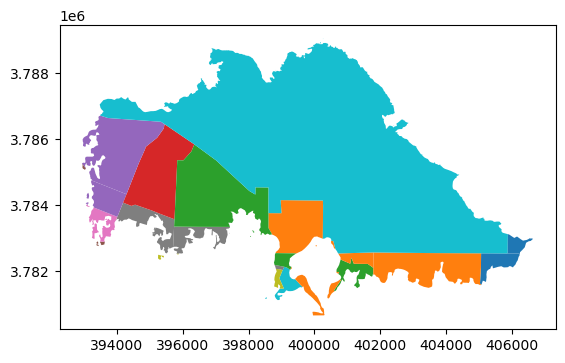

In [24]:
clip_eji_eaton.plot('TRACTCE')

### 11. Visualize fire perimeters with a basemap 
Using the package `contextily` we can add a base map to contextualize the fire areas within the greater Los Angeles Area.


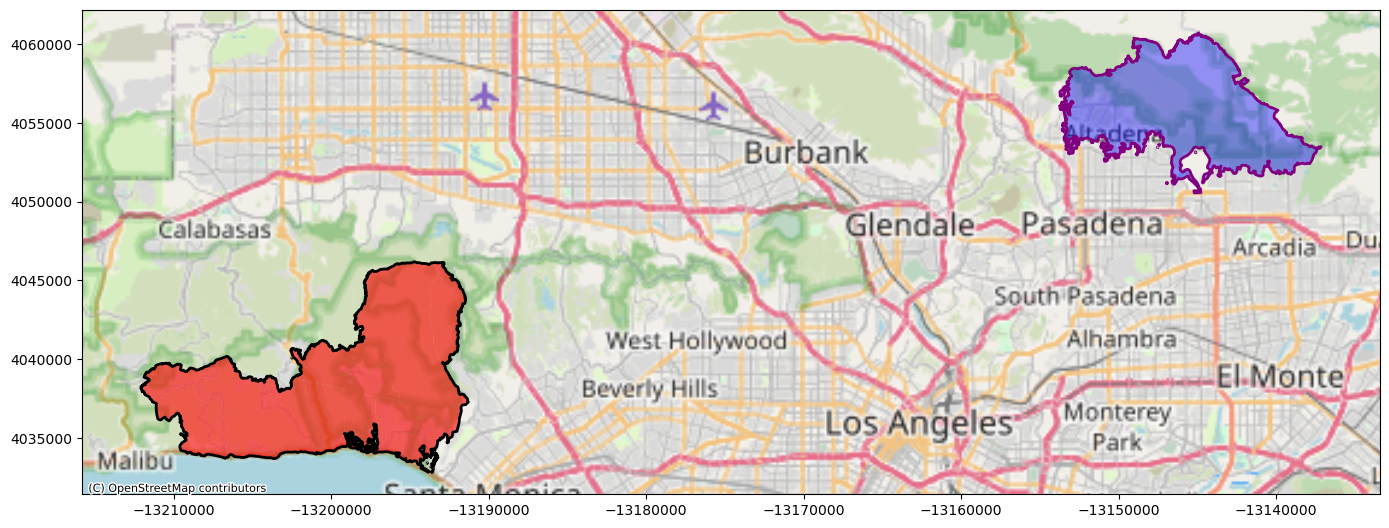

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.ticklabel_format(style='plain')


# 1. Reproject everything to EPSG:3857
clip_eji_pali_3857      = clip_eji_pali.to_crs(epsg=3857)
clip_eji_eaton_3857     = clip_eji_eaton.to_crs(epsg=3857)
palisades_perimeter_3857 = palisades_perimeter.to_crs(epsg=3857)
eaton_perimeter_3857     = eaton_perimeter.to_crs(epsg=3857)

# 2. Plot layers
clip_eji_pali_3857.plot(
    ax=ax, facecolor='red', alpha=0.6, edgecolor='none'
)
clip_eji_eaton_3857.plot(
    ax=ax, facecolor='blue', alpha=0.4, edgecolor='none'
)

palisades_perimeter_3857.plot(
    ax=ax, color='none', edgecolor='black', linewidth=2
)
eaton_perimeter_3857.plot(
    ax=ax, color='none', edgecolor='purple', linewidth=2
)

# 3. Add basemap last
ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()


This plot turns highlights the neighborhoods which were effected, as well as showing just how close to more densly populated areas the fires got. 

### 12. Mapping socioecomic factors
For this section I chose to examine the percentage of the census tracts which were renters. I chose this because, following the fires, renters faced issues with: 
- Loss of homes
- Rent increases (double to triple the price)
- Landlords trying to push out long-term renters who pay lower rents to make way for displaced fire victims who have more money to spend
- Paying out of pocket to clean and fix partially damaged rental space
[@CBSNews_2025_WildfireSurvivors]

These issues compound the already devistating fire and reduce quality of life for renters.

To plot this I used the percentage of census tracts which are renters. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 12))

# Set eji variable of interest
eji_variable = 'E_RENTER'

# Find common min/max for legend range
vmin = min(clip_eji_pali[eji_variable].min(), clip_eji_eaton[eji_variable].min())
vmax = max(clip_eji_pali[eji_variable].max(), clip_eji_eaton[eji_variable].max())

# Plot census tracts within Palisades perimeter
clip_eji_pali.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
)
ax1.set_title('Palisades Fire')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
clip_eji_eaton.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
)
ax2.set_title('Eaton Fire')
ax2.axis('off')

# Add overall title
fig.suptitle('Renter occupied buildings in Palisades and Eaton Fires',
             y=0.7) # Y = .7 sets height of title



# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percent Renters')

plt.show()

From the map you can see that the Palisades fire affected more renters, with a large area of close to 50% renters being found at the lower left of the perimeter (Malibu). While this is an affluent area, it has seen some of the highest level of post-fire price gouging [@FOXLA_2025]. This could alienate those who have historically lived in the communities to move elsewhere, shifting the social and demographic makeup of these areas.